In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
sns.set_palette(["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"])
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

from sklearn.preprocessing import LabelEncoder, FunctionTransformer, Binarizer, MinMaxScaler
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from scipy.sparse import csr_matrix, hstack

import lightgbm as lgb

#from pdpbox import pdp
import shap
shap.initjs()

import gc

# Preprocessing

In [2]:
data_int = pd.read_csv('../new_data/data_int.csv', index_col=0)
data_auc = pd.read_csv('../new_data/data_auc.csv', index_col=0)

metadata = pd.read_csv('../new_data/metadata_clean.csv', index_col=0)

In [3]:
data_int.head()

,0,1,2,3,4,5,6,7,8,9,...,44826,44827,44828,44829,44830,44831,44832,44833,44834,44835
19777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
19778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,933.0,907.0,0.0,0.0,3784.0,0.0,0.0,101.0,81.0,0.0
19779,0.0,0.0,0.0,0.0,622.0,0.0,0.0,0.0,0.0,0.0,...,0.0,92.0,2590.0,2349.0,2326.0,0.0,0.0,64.0,36.0,1785.0
19780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3596.0,0.0,0.0,0.0,9.0,35.0,2018.0
19781,0.0,0.0,0.0,33.0,775.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,46.0,0.0,0.0,1.0,0.0,0.0


In [4]:
metadata.head()

,strain,genus,species,elevation,province,pH,temperature,moisture,soiltype,media
19777,409,Xenorhabdus,stockiae,186,phitsanulok,6.8,28,1.0,loam,LB
19789,409,Xenorhabdus,stockiae,186,phitsanulok,6.8,28,1.0,loam,SF900
19817,432,Photorhabdus,luminescens,243,phitsanulok,6.6,26,1.5,sandy loam,LB
19818,433,Photorhabdus,luminescens,243,phitsanulok,6.8,27,1.0,sandy loam,LB
19819,434,Photorhabdus,luminescens,255,phitsanulok,6.8,27,1.0,sandy loam,LB


## Visualising the distribution of genera w/r/t metadata

Let's first explore the distribution of numerical metadata

In [5]:
metadata[['pH', 'temperature', 'moisture', 'elevation']].describe()

,pH,temperature,moisture,elevation
count,228.000000,228.000000,228.000000,228.000000
mean,6.728070,26.929825,1.635965,371.938596
std,0.333057,3.272417,1.178525,385.358196
min,5.200000,18.000000,0.500000,0.000000
25%,6.600000,26.000000,1.000000,114.000000
50%,6.800000,28.000000,1.000000,226.000000
75%,7.000000,29.000000,2.000000,348.000000
max,7.000000,32.000000,8.000000,1291.000000


The model we will be using is based on decision trees and therefore it's robust to different feature scalings and to outliers. For ease of visualisation, however, we rescale the numerical data so that pH, temperature and moisture lie between 0 and 1, and the elevation&mdash;which originally spans three orders of magnitude&mdash;is log-transformed.

In [6]:
scaler = MinMaxScaler()
metadata[['pH', 'temperature', 'moisture']] = scaler.fit_transform(metadata[['pH', 'temperature', 'moisture']])

metadata.elevation = metadata.elevation.apply(np.log1p)

Now we plot the distribution of the genera, and see that it appears to be more or less evenly distributed with respect to these variables.

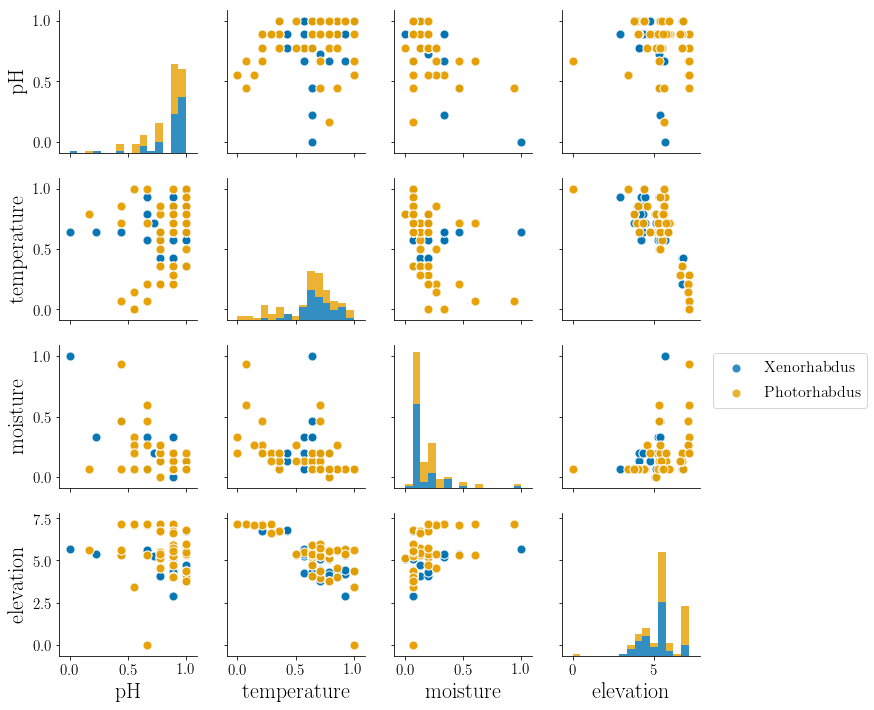

In [7]:
ax = sns.pairplot(metadata, vars=['pH', 'temperature', 'moisture', 'elevation'], hue='genus', palette=colours[5::-4], kind='scatter',
             diag_kind='hist', diag_kws=dict(alpha=0.8, bins=15), plot_kws=dict(alpha=0.8, s=80))
ax._legend.remove()
plt.legend(fontsize=16, bbox_to_anchor=(1.04,1), loc="upper left")
#plt.savefig('../new_figures/numerical_metadata.pdf', bbox_inches='tight')

For the rest of the geographical metadata, the situation is similar.

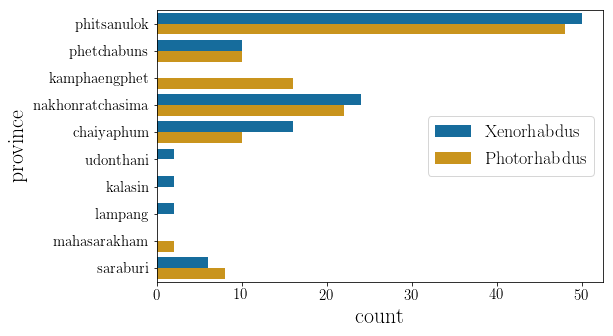

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(y='province', data=metadata, hue='genus', palette=colours[5::-4])
plt.legend(fontsize=18)
#plt.savefig('../new_figures/province.pdf', bbox_inches='tight')

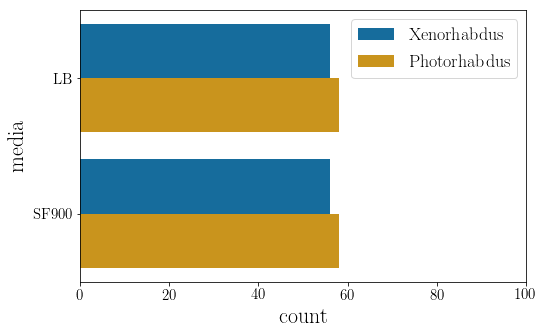

In [9]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(y='media', data=metadata, hue='genus', palette=colours[5::-4])
plt.xlim(0,100)
plt.legend(fontsize=18)
#plt.savefig('../new_figures/medium.pdf', bbox_inches='tight')

Text(0,0.5,'soil type')

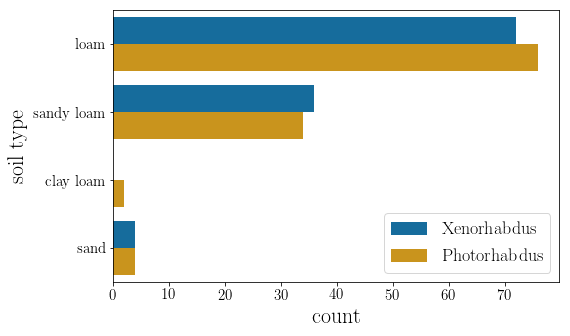

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(y='soiltype', data=metadata, hue='genus', palette=colours[5::-4])
plt.legend(fontsize=18)
plt.ylabel('soil type')
#plt.savefig('../new_figures/soil.pdf', bbox_inches='tight')

As a last step, we need to turn these categorical features into numerical ones. Since there is no specific ordering among the feature values of any of these columns, we apply one-hot encoding.

In [11]:
metadata = pd.get_dummies(metadata, columns=['media', 'province', 'soiltype'])
metadata.head()

,strain,genus,species,elevation,pH,temperature,moisture,media_LB,media_SF900,province_chaiyaphum,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,409,Xenorhabdus,stockiae,5.231109,0.888889,0.714286,0.066667,1,0,0,...,0,0,0,1,0,0,0,1,0,0
19789,409,Xenorhabdus,stockiae,5.231109,0.888889,0.714286,0.066667,0,1,0,...,0,0,0,1,0,0,0,1,0,0
19817,432,Photorhabdus,luminescens,5.497168,0.777778,0.571429,0.133333,1,0,0,...,0,0,0,1,0,0,0,0,0,1
19818,433,Photorhabdus,luminescens,5.497168,0.888889,0.642857,0.066667,1,0,0,...,0,0,0,1,0,0,0,0,0,1
19819,434,Photorhabdus,luminescens,5.545177,0.888889,0.642857,0.066667,1,0,0,...,0,0,0,1,0,0,0,0,0,1


We save this for future use.

In [12]:
metadata.to_csv('../new_data/model/metadata.csv')

## Metabolite data

### Rescaling and removal of poor predictors

We start by peeking at a few columns of the data.

In [12]:
data_int[data_int.columns[:10]].describe()

,0,1,2,3,4,5,6,7,8,9
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,48.076923,196.560440,18.129121,44.395604,235.387363,180.442308,28.711538,382.513736,1221.489011,272.335165
std,896.676271,998.021017,345.881582,644.709812,414.779321,2760.100777,521.092904,1005.280248,3892.201639,1389.553042
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,93.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,377.250000,0.000000,0.000000,0.000000,31.000000,29.000000
max,17104.000000,9861.000000,6599.000000,12299.000000,5638.000000,51257.000000,9942.000000,5773.000000,30253.000000,10452.000000


In [13]:
data_auc[data_auc.columns[:10]].describe()

,0,1,2,3,4,5,6,7,8,9
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,140.554011,706.054003,59.092418,150.725187,670.925295,521.973140,95.691795,116.704959,1456.295861,665.876896
std,2609.647928,3497.228104,1127.411473,2472.620855,1464.161092,7735.987197,1752.560518,307.936574,4598.554307,3548.824653
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,62.445250,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,836.579500,0.000000,0.000000,0.000000,11.105500,42.487250
max,49773.375000,32889.396500,21509.640000,47184.761000,20737.809000,142852.257000,33438.115000,1610.047000,34814.323000,30485.268000


We observe that the metabolite intensity and AUC are extremely skewed and span several orders of magnitude. We transform them to log scale for ease of visualisation&mdash;recall that tree-based algorithms are robust to feature scalings and outliers.

In [14]:
data_int = np.log1p(data_int)
data_auc = np.log1p(data_auc)

Let's visualise what a single sample from the intensity dataset looks like

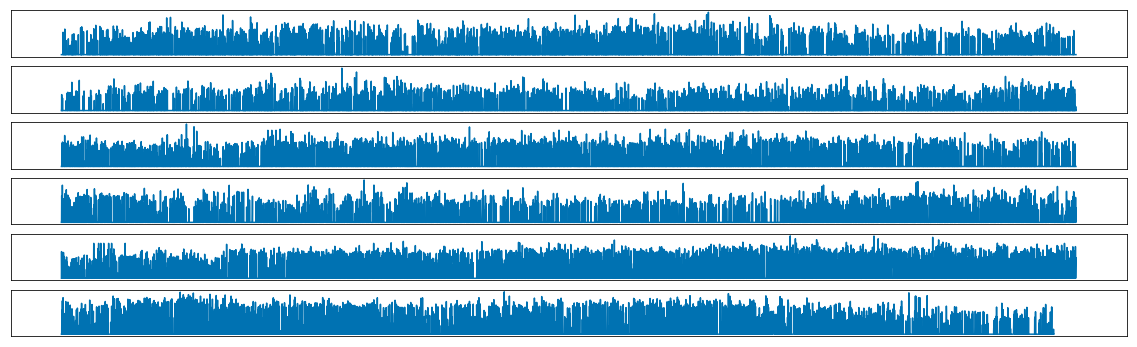

In [15]:
fig, axes = plt.subplots(6,figsize=(20,12), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(data_int.iloc[0].values[7500*i:min(7500*(i+1), data_int.shape[1])], c=colours[5])
    ax.set_yticks([])
    ax.set_xticks([])
#plt.savefig('../new_figures/1sample.pdf', bbox_iches='tight')

And one single peak across samples

Text(0.5,0,'log intensity peak 3')

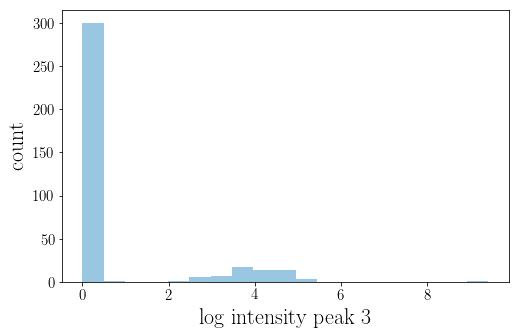

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(data_int[data_int.columns[3]], kde=False, color=colours[5])
plt.ylabel('count')
plt.xlabel('log intensity peak '+data_int.columns[3])
#plt.savefig('../new_figures/1peak.pdf', bbox_inches='tight')

Now, we remove any constant columns (zero variance) from the metabolite data, since they will not contribute to the classification. In this case, the constant will be equal to zero, indicating that a certain metabolite is not present in *any* of the samples. Furthermore, we can remove near-zero-variance features, *i.e.*, metabolites that are only present in very few of the samples, anticipating that they will also be poor class predictors. We set the threshold at 20 values, which is ca. 10% of the samples.

In [17]:
nothing_int = [col for col in data_int.columns if len(data_int[col].nonzero()[0]) == 0]
nothing_auc = [col for col in data_auc.columns if len(data_auc[col].nonzero()[0]) == 0]

print('Number of constant columns in intensity data: %i' % len(nothing_int))
print('Number of constant columns in AUC data: %i' % len(nothing_auc))

Number of constant columns in intensity data: 796
Number of constant columns in AUC data: 785


In [18]:
data_int_Z = data_int.drop(nothing_int, axis=1)
data_auc_Z = data_auc.drop(nothing_auc, axis=1)

In [19]:
nothing_int = [col for col in data_int.columns if len(data_int[col].nonzero()[0]) <= 20]
nothing_auc = [col for col in data_auc.columns if len(data_auc[col].nonzero()[0]) <= 20]

print('Number of near-zero-variance columns in intensity data: %i' % len(nothing_int))
print('Number of near-zero-variance columns in AUC data: %i' % len(nothing_auc))

Number of near-zero-variance columns in intensity data: 11565
Number of near-zero-variance columns in AUC data: 11323


In [20]:
data_int_NZ = data_int.drop(nothing_int, axis=1)
data_auc_NZ = data_auc.drop(nothing_auc, axis=1)

We save both the dataset with removal of zero-variance features and the one with removal of near-zero-variance features for each type of data, for future comparison.

In [83]:
data_int_Z.to_csv('../new_data/model/data_int_Z.csv')
data_auc_Z.to_csv('../new_data/model/data_auc_Z.csv')

data_int_NZ.to_csv('../new_data/model/data_int_NZ.csv')
data_auc_NZ.to_csv('../new_data/model/data_auc_NZ.csv')

### Clustering of correlated features

Tree-based methods are also robust to highly correlated features: for a given split, they choose one of them ignoring the others. This robustness is good from a performance point of view, but the ignored features will not show up in an importance ranking, so that we may lose valuable information when interpreting the model. For this reason, we decide to cluster highly correlated features, removing from the dataset all but one member of any one cluster, but saving the cluster themselves, in order to go back to this data after determining the feature importances.

**This is where I am now. The argument above still holds, but the argument 'by inspection' doesn't. The dataset without near-zero-variance columns still has over 40000 features (instead of ca. 15000 from the original data), and it's not easy to visualise non-overlapping regions as before (see fig below).**

**I will run the model without cluster removal first. For the clusters, hopefully the system can handle the correlation matrix for the number of columns.**

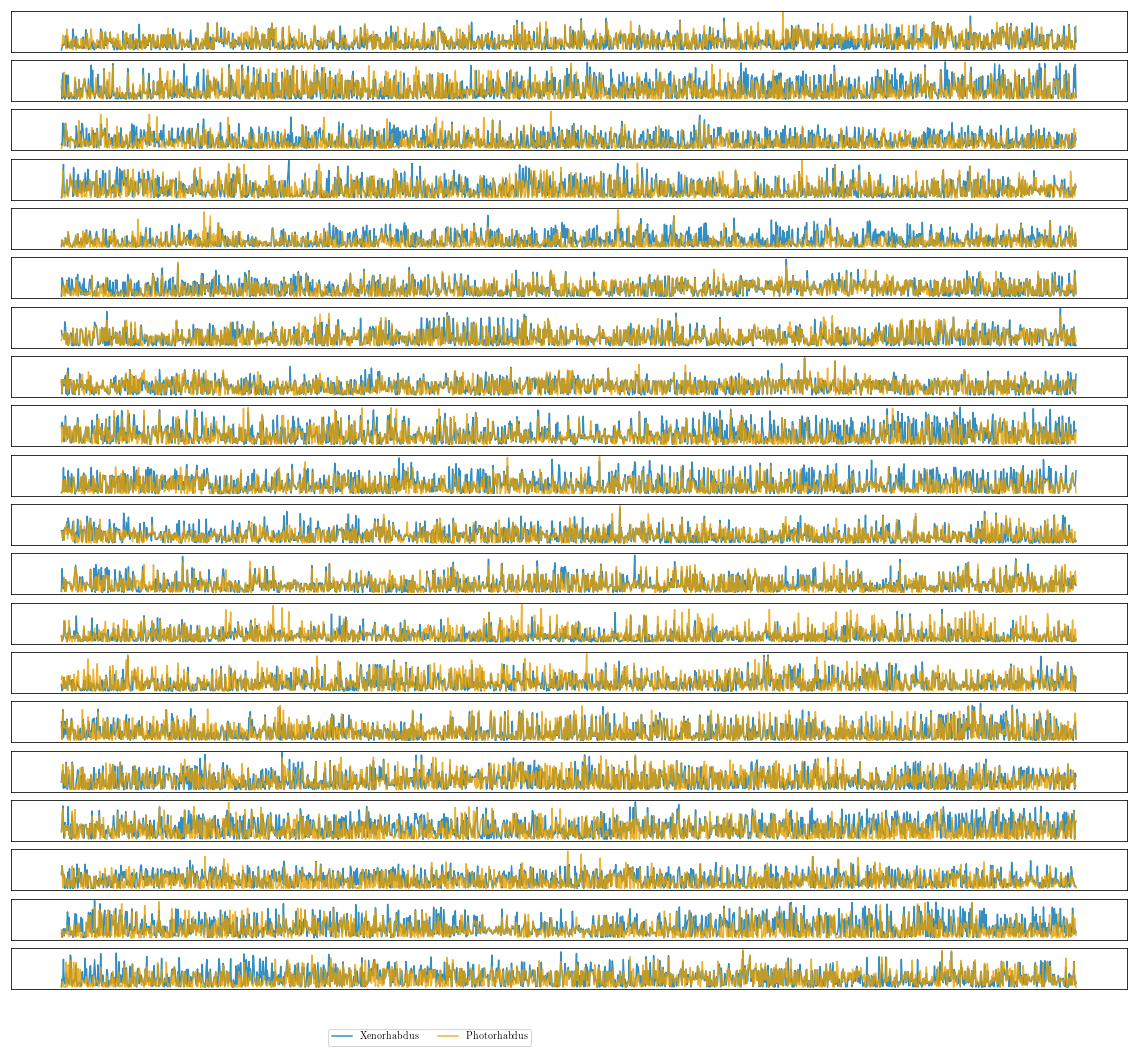

In [34]:
xenomean = data_int_NZ.loc[metadata[metadata.genus=='Xenorhabdus'].index].mean(axis=0).values
photomean = data_int_NZ.loc[metadata[metadata.genus=='Photorhabdus'].index].mean(axis=0).values

fig, axes = plt.subplots(20,figsize=(20,18), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(xenomean[1500*i:min(1500*(i+1), xenomean.shape[0])], alpha=0.8, c=colours[5], label='Xenorhabdus')
    ax.plot(photomean[1500*i:min(1500*(i+1), photomean.shape[0])], alpha=0.8, c=colours[1], label='Photorhabdus')
    ax.set_yticks([])
    ax.set_xticks([])
plt.legend(loc='lower left', bbox_to_anchor=(0.28, -1.5), ncol=2)